# LSTM using Keras


## Getting started
A good [article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) about the theory of LSTM RNNs.
<br>
Intro to LSTM using Keras in a hands on [article](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/).
<br><br>
The practical article explains how to use LSTM to predict the graph of number of international airline passengers per month.
<img style="width:600px" src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/07/LSTM-Trained-on-Regression-Formulation-of-Passenger-Prediction-Problem-1.png">
As we can see, there is a noticable pattern in the graph, so it should be easily predictable.
<br>
A simple NN should be able to learn the function of the graph and predict it and we can see that it actually does - the blue is the actual graph, the green is the prediction of the training set and the red is the prediction of the testing set.
<br><br>
Stock prices are much more chaotic and can't be so predictable, but I just wanted to give it a try and apply the same method on the graph of the "Close" prices of the Facebook stock.
<br>

The following code is the code from the article (**it's not my code**). I made some small modifications to the code in order to execute on the facebook stock data and be able to get general parameters.
<br>
This following model uses an LSTM network with the following configuration:
- 1 input layer
- 1 output layer
- 2 LSTM layers (4 neurons each)
- Saving sequence state between the iterations of every epoch
- Resetting the state after every epoch

In [1]:
import math
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [3]:
def learn_and_predict(epochs, look_back=3):
    # convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])

        return numpy.array(dataX), numpy.array(dataY)

    # fix random seed for reproducibility
    numpy.random.seed(7)

    # load the dataset
    dataframe = read_csv('~/code/dscience/stocks/data/facebook.csv', usecols=[4], engine='python', skipfooter=3)
    dataset = dataframe.values
    dataset = dataset.astype('float32')

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    # create and fit the LSTM network
    batch_size = 1
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(epochs):
        print("epoch {}".format(i + 1))
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()

    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
    actualPlot = scaler.inverse_transform(dataset)
    
    return actualPlot, trainPredictPlot, testPredictPlot

#### Run 100 epochs with batch_size=1 (default) and a window size of 10:

In [3]:
actualPlot, trainPredictPlot, testPredictPlot = learn_and_predict(100, 10)

Instructions for updating:
Colocations handled automatically by placer.
epoch 1
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 15s - loss: 2.8743e-04
epoch 2
Epoch 1/1
 - 14s - loss: 0.0010
epoch 3
Epoch 1/1
 - 13s - loss: 8.7839e-04
epoch 4
Epoch 1/1
 - 15s - loss: 7.1724e-04
epoch 5
Epoch 1/1
 - 14s - loss: 5.1728e-04
epoch 6
Epoch 1/1
 - 13s - loss: 4.3035e-04
epoch 7
Epoch 1/1
 - 13s - loss: 3.4095e-04
epoch 8
Epoch 1/1
 - 14s - loss: 3.0775e-04
epoch 9
Epoch 1/1
 - 15s - loss: 2.8337e-04
epoch 10
Epoch 1/1
 - 12s - loss: 2.7183e-04
epoch 11
Epoch 1/1
 - 14s - loss: 2.6266e-04
epoch 12
Epoch 1/1
 - 16s - loss: 2.5265e-04
epoch 13
Epoch 1/1
 - 15s - loss: 2.3144e-04
epoch 14
Epoch 1/1
 - 15s - loss: 1.8603e-04
epoch 15
Epoch 1/1
 - 15s - loss: 1.3697e-04
epoch 16
Epoch 1/1
 - 14s - loss: 1.2039e-04
epoch 17
Epoch 1/1
 - 14s - loss: 1.1777e-04
epoch 18
Epoch 1/1
 - 15s - loss: 1.1525e-04
epoch 19
Epoch 1/1
 - 12s - loss: 1.1081e-04
epoch 20
Epoch 1/1
 - 13s - loss: 1.05

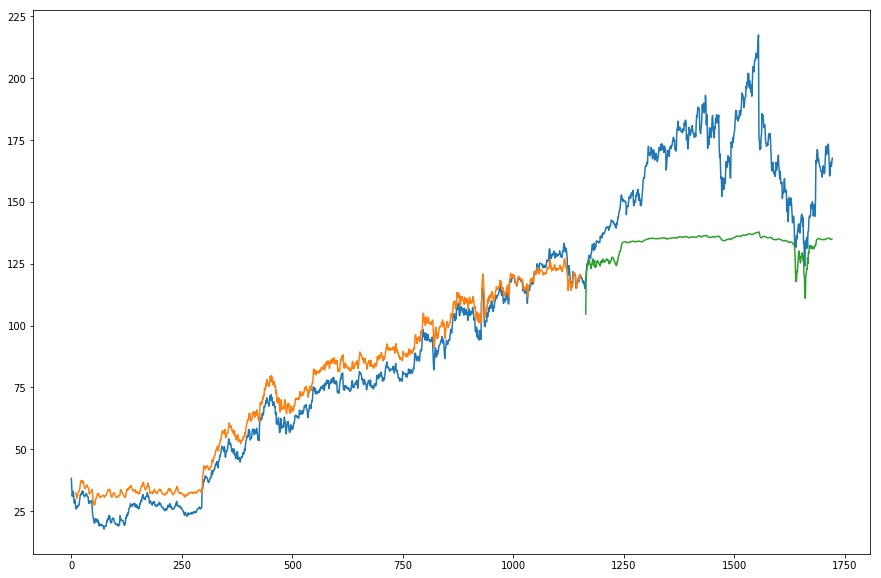

In [4]:
# plot baseline and predictions
plt.figure(figsize=(15,10))
plt.plot(actualPlot)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that it takes **much** longer to train a model of RNN comparing to a simple polynomial regression.
<br>
Many epochs are needed in order to converge and minimize the loss. Each epoch goes through the entire dataset and calculates the weights of the model. It takes 12s in average for every epoch in this configuration.
<br>
I also tried running it with different configurations and got the evidence that if I increase the batch size, each epoch runs faster, but it takes much more time to converge. The loss may go up and down many times.

#### Some observations:
- The predictions on the training set are pretty good (maybe due to overfitting).
- The preidctions on the testing set on first days are more or less close to actual, but as the days pass and we are predicting more to the future, the prediction are far away from the actual values.
- LSTM RMSE - on the training set: 6.897
- LSTM RMSE - on the testing set: 34.42
- Linear Regression RMSE - 3.38

#### Intermmediate Conclusions:
- This model configuration may not be optimal. I may spend a lot of time on finding the right model configuration that will fit the best and on finding different performance/model optimization methods.
- It's useless to predict so far to the future.
- Therefore it's also probably useless to look too much time back to the past when training the model. i.e. window size shouldn't be that large.
- I need to get back to my initial training and validation method of training on last X days and predicting the following day

#### Plan:
1. Run the same network with the previous training-validation method and try to get RMSE < 3.38
1. If I won't get the same RMSE, try to increase window size to cover the whole dataset + find ways to optimize model training time (maybe run Keras on a machine with GPU)
1. When getting to RMSE of 3.38 - change the network to include more layers (verify that the model is not overfitting).
1. Use more features (Open, Volume, etc) - check if it decreases the loss.
1. Try to edit the Forget gates of the LSTM layers in order to control the weights of past days. This way we'll be able to increase the window size and give more impact to the last days
1. Try stocks with lower volatility. Facebook stock is pretty volatile - it has a Beta value of 1.2 for the last 3Y Monthly, while Pepsi stock has a Beta value of 0.5

In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM


def predict_close_lstm(df, cur_day, num_of_days, window_size=10, look_back=4, epochs=100, plot=False, plot_callback=None, loss_threshold=1e-4):
    actuals = []
    predictions = []

    # Go through all requested days and make a new training for every day
    for i in range(cur_day, cur_day + num_of_days):
        print("Training day {}/{}".format(i - cur_day, num_of_days))
        # For each day, train a new model using Close values of previous days.
        # Number of previous days is defined by "window_size"
        samples_start = i - window_size
        samples_end = i - 1

        # Important!
        # The training set will be taken from [samples_start:samples_end + 1]
        # and the last sample is for the prediction of next day
        df_cur_dataset = df[samples_start:samples_end + 2]

        actual, predicted = train_lstm(df_cur_dataset, look_back, epochs, plot=plot, plot_callback=plot_callback, loss_threshold=loss_threshold)
        actuals.append(actual)
        predictions.append(predicted)

    return actuals, predictions


def train_lstm(df, look_back, epochs, plot=False, plot_callback=None, loss_threshold=10**-4):
    # Normalize the whole dataset (this will include Xs and Ys)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(df.values.astype('float32'))

    # reshape into X=t and Y=t+1
    train_x, train_y, x_inc_predict, y_inc_predict = create_lstm_dataset(dataset, look_back)

    # reshape input to be [samples, time steps, features]
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    x_inc_predict = np.reshape(x_inc_predict, (x_inc_predict.shape[0], x_inc_predict.shape[1], 1))

    # create and fit the LSTM network
    batch_size = 1
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(epochs):
        #print("epoch {}".format(i + 1))
        res = model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        if res.history["loss"][0] < loss_threshold:
            print("Loss is lower than threshold of {}. Quitting.".format(loss_threshold))
            break

    # make predictions
    train_predict = model.predict(x_inc_predict, batch_size=batch_size)
    model.reset_states()

    # invert predictions
    train_y = scaler.inverse_transform([train_y])
    train_predict = scaler.inverse_transform(train_predict)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(train_y[0], train_predict[:-1, 0]))
    print('Train Score: %.2f RMSE' % (trainScore))

    # shift train predictions for plotting
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

    if plot_callback:
        plot_callback(scaler.inverse_transform(dataset), train_predict_plot)

    if plot:
        # plot baseline and predictions
        plt.figure(figsize=(15, 10))
        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(train_predict_plot)
        plt.show()

    actual = train_y[0]
    predicted = train_predict[:-1, 0]

    return actual, predicted


def create_lstm_dataset(dataset, look_back=1):
    # Actual training set
    data_x, data_y = [], []

    # X and Y sets that include the last sample (which is not part of the training set)
    # This will be used for predicting and ploting the next day
    data_inc_predict_x, data_inc_predict_y = [], []

    def add_i_features(ds_x, ds_y, i):
        # Append to the list of timeseries, a 1 dimensional array that
        # includes values of our single feature (index 0) across current look_back range
        ds_x.append(dataset[i:(i + look_back), 0])

        # Append to the list of Ys, the y of the current look_back, which is our feature
        # of next day after our look_back range
        ds_y.append(dataset[i + look_back, 0])

    # Go through all training samples
    # For example
    # if the windows size is 10
    # 11 samples will be passed
    # samples 0-9 will be used for the training set
    # sample 10 will be used for the prediction
    for i in range(len(dataset) - look_back - 1):
        add_i_features(data_x, data_y, i)
        add_i_features(data_inc_predict_x, data_inc_predict_y, i)

    # Add the last sample for prediction purposes
    add_i_features(data_inc_predict_x, data_inc_predict_y, i + 1)

    return np.array(data_x), np.array(data_y), np.array(data_inc_predict_x), np.array(data_inc_predict_y)


In [9]:
# If we don't have a fixed seed, every time that I train the model, it predicts different results.
# Probably we should make enough epochs in order to get to a very small loss in order to get deterministic results
np.random.seed(7)

# Read data
df = read_csv('~/code/dscience/stocks/data/facebook.csv', usecols=["Close"], engine='python', skipfooter=3)

# A callback to save plot data from within the training function in order to be able to plot the data in a different cell in Jupyter.
ds1 = None
ds2 = None
def save_plot_data(original_dataset, predicted_shifted_dataset):
    global ds1
    global ds2
    ds1 = original_dataset
    ds2 = predicted_shifted_dataset
numebr_of_days = 1
first_day = int(len(df) / 2)
res_actuals, res_predicted = predict_close_lstm(df, first_day, numebr_of_days, window_size=10, look_back=4, epochs=5000, plot=False, plot_callback=save_plot_data, loss_threshold=1e-4)

Training day 0/1
epoch 1
Epoch 1/1
 - 2s - loss: 0.4646
epoch 2
Epoch 1/1
 - 0s - loss: 0.4373
epoch 3
Epoch 1/1
 - 0s - loss: 0.4107
epoch 4
Epoch 1/1
 - 0s - loss: 0.3849
epoch 5
Epoch 1/1
 - 0s - loss: 0.3595
epoch 6
Epoch 1/1
 - 0s - loss: 0.3341
epoch 7
Epoch 1/1
 - 0s - loss: 0.3085
epoch 8
Epoch 1/1
 - 0s - loss: 0.2822
epoch 9
Epoch 1/1
 - 0s - loss: 0.2552
epoch 10
Epoch 1/1
 - 0s - loss: 0.2274
epoch 11
Epoch 1/1
 - 0s - loss: 0.1991
epoch 12
Epoch 1/1
 - 0s - loss: 0.1705
epoch 13
Epoch 1/1
 - 0s - loss: 0.1424
epoch 14
Epoch 1/1
 - 0s - loss: 0.1155
epoch 15
Epoch 1/1
 - 0s - loss: 0.0908
epoch 16
Epoch 1/1
 - 0s - loss: 0.0693
epoch 17
Epoch 1/1
 - 0s - loss: 0.0518
epoch 18
Epoch 1/1
 - 0s - loss: 0.0385
epoch 19
Epoch 1/1
 - 0s - loss: 0.0294
epoch 20
Epoch 1/1
 - 0s - loss: 0.0238
epoch 21
Epoch 1/1
 - 0s - loss: 0.0207
epoch 22
Epoch 1/1
 - 0s - loss: 0.0191
epoch 23
Epoch 1/1
 - 0s - loss: 0.0185
epoch 24
Epoch 1/1
 - 0s - loss: 0.0182
epoch 25
Epoch 1/1
 - 0s - loss:

 - 0s - loss: 0.0115
epoch 204
Epoch 1/1
 - 0s - loss: 0.0115
epoch 205
Epoch 1/1
 - 0s - loss: 0.0115
epoch 206
Epoch 1/1
 - 0s - loss: 0.0115
epoch 207
Epoch 1/1
 - 0s - loss: 0.0114
epoch 208
Epoch 1/1
 - 0s - loss: 0.0114
epoch 209
Epoch 1/1
 - 0s - loss: 0.0114
epoch 210
Epoch 1/1
 - 0s - loss: 0.0114
epoch 211
Epoch 1/1
 - 0s - loss: 0.0113
epoch 212
Epoch 1/1
 - 0s - loss: 0.0113
epoch 213
Epoch 1/1
 - 0s - loss: 0.0113
epoch 214
Epoch 1/1
 - 0s - loss: 0.0113
epoch 215
Epoch 1/1
 - 0s - loss: 0.0112
epoch 216
Epoch 1/1
 - 0s - loss: 0.0112
epoch 217
Epoch 1/1
 - 0s - loss: 0.0112
epoch 218
Epoch 1/1
 - 0s - loss: 0.0112
epoch 219
Epoch 1/1
 - 0s - loss: 0.0111
epoch 220
Epoch 1/1
 - 0s - loss: 0.0111
epoch 221
Epoch 1/1
 - 0s - loss: 0.0111
epoch 222
Epoch 1/1
 - 0s - loss: 0.0111
epoch 223
Epoch 1/1
 - 0s - loss: 0.0110
epoch 224
Epoch 1/1
 - 0s - loss: 0.0110
epoch 225
Epoch 1/1
 - 0s - loss: 0.0110
epoch 226
Epoch 1/1
 - 0s - loss: 0.0110
epoch 227
Epoch 1/1
 - 0s - loss: 0.

 - 0s - loss: 0.0079
epoch 404
Epoch 1/1
 - 0s - loss: 0.0078
epoch 405
Epoch 1/1
 - 0s - loss: 0.0078
epoch 406
Epoch 1/1
 - 0s - loss: 0.0078
epoch 407
Epoch 1/1
 - 0s - loss: 0.0078
epoch 408
Epoch 1/1
 - 0s - loss: 0.0078
epoch 409
Epoch 1/1
 - 0s - loss: 0.0078
epoch 410
Epoch 1/1
 - 0s - loss: 0.0078
epoch 411
Epoch 1/1
 - 0s - loss: 0.0078
epoch 412
Epoch 1/1
 - 0s - loss: 0.0077
epoch 413
Epoch 1/1
 - 0s - loss: 0.0077
epoch 414
Epoch 1/1
 - 0s - loss: 0.0076
epoch 415
Epoch 1/1
 - 0s - loss: 0.0076
epoch 416
Epoch 1/1
 - 0s - loss: 0.0075
epoch 417
Epoch 1/1
 - 0s - loss: 0.0074
epoch 418
Epoch 1/1
 - 0s - loss: 0.0073
epoch 419
Epoch 1/1
 - 0s - loss: 0.0073
epoch 420
Epoch 1/1
 - 0s - loss: 0.0072
epoch 421
Epoch 1/1
 - 0s - loss: 0.0071
epoch 422
Epoch 1/1
 - 0s - loss: 0.0070
epoch 423
Epoch 1/1
 - 0s - loss: 0.0070
epoch 424
Epoch 1/1
 - 0s - loss: 0.0069
epoch 425
Epoch 1/1
 - 0s - loss: 0.0068
epoch 426
Epoch 1/1
 - 0s - loss: 0.0068
epoch 427
Epoch 1/1
 - 0s - loss: 0.

 - 0s - loss: 0.0061
epoch 604
Epoch 1/1
 - 0s - loss: 0.0061
epoch 605
Epoch 1/1
 - 0s - loss: 0.0061
epoch 606
Epoch 1/1
 - 0s - loss: 0.0061
epoch 607
Epoch 1/1
 - 0s - loss: 0.0061
epoch 608
Epoch 1/1
 - 0s - loss: 0.0061
epoch 609
Epoch 1/1
 - 0s - loss: 0.0061
epoch 610
Epoch 1/1
 - 0s - loss: 0.0060
epoch 611
Epoch 1/1
 - 0s - loss: 0.0060
epoch 612
Epoch 1/1
 - 0s - loss: 0.0060
epoch 613
Epoch 1/1
 - 0s - loss: 0.0060
epoch 614
Epoch 1/1
 - 0s - loss: 0.0060
epoch 615
Epoch 1/1
 - 0s - loss: 0.0060
epoch 616
Epoch 1/1
 - 0s - loss: 0.0060
epoch 617
Epoch 1/1
 - 0s - loss: 0.0060
epoch 618
Epoch 1/1
 - 0s - loss: 0.0060
epoch 619
Epoch 1/1
 - 0s - loss: 0.0060
epoch 620
Epoch 1/1
 - 0s - loss: 0.0060
epoch 621
Epoch 1/1
 - 0s - loss: 0.0060
epoch 622
Epoch 1/1
 - 0s - loss: 0.0060
epoch 623
Epoch 1/1
 - 0s - loss: 0.0060
epoch 624
Epoch 1/1
 - 0s - loss: 0.0060
epoch 625
Epoch 1/1
 - 0s - loss: 0.0059
epoch 626
Epoch 1/1
 - 0s - loss: 0.0059
epoch 627
Epoch 1/1
 - 0s - loss: 0.

 - 0s - loss: 0.0062
epoch 804
Epoch 1/1
 - 0s - loss: 0.0051
epoch 805
Epoch 1/1
 - 0s - loss: 0.0089
epoch 806
Epoch 1/1
 - 0s - loss: 0.0063
epoch 807
Epoch 1/1
 - 0s - loss: 0.0071
epoch 808
Epoch 1/1
 - 0s - loss: 0.0062
epoch 809
Epoch 1/1
 - 0s - loss: 0.0067
epoch 810
Epoch 1/1
 - 0s - loss: 0.0068
epoch 811
Epoch 1/1
 - 0s - loss: 0.0063
epoch 812
Epoch 1/1
 - 0s - loss: 0.0077
epoch 813
Epoch 1/1
 - 0s - loss: 0.0051
epoch 814
Epoch 1/1
 - 0s - loss: 0.0062
epoch 815
Epoch 1/1
 - 0s - loss: 0.0052
epoch 816
Epoch 1/1
 - 0s - loss: 0.0081
epoch 817
Epoch 1/1
 - 0s - loss: 0.0063
epoch 818
Epoch 1/1
 - 0s - loss: 0.0069
epoch 819
Epoch 1/1
 - 0s - loss: 0.0064
epoch 820
Epoch 1/1
 - 0s - loss: 0.0061
epoch 821
Epoch 1/1
 - 0s - loss: 0.0065
epoch 822
Epoch 1/1
 - 0s - loss: 0.0057
epoch 823
Epoch 1/1
 - 0s - loss: 0.0084
epoch 824
Epoch 1/1
 - 0s - loss: 0.0053
epoch 825
Epoch 1/1
 - 0s - loss: 0.0065
epoch 826
Epoch 1/1
 - 0s - loss: 0.0055
epoch 827
Epoch 1/1
 - 0s - loss: 0.

 - 0s - loss: 0.0051
epoch 1004
Epoch 1/1
 - 0s - loss: 0.0051
epoch 1005
Epoch 1/1
 - 0s - loss: 0.0052
epoch 1006
Epoch 1/1
 - 0s - loss: 0.0052
epoch 1007
Epoch 1/1
 - 0s - loss: 0.0051
epoch 1008
Epoch 1/1
 - 0s - loss: 0.0053
epoch 1009
Epoch 1/1
 - 0s - loss: 0.0052
epoch 1010
Epoch 1/1
 - 0s - loss: 0.0052
epoch 1011
Epoch 1/1
 - 0s - loss: 0.0055
epoch 1012
Epoch 1/1
 - 0s - loss: 0.0051
epoch 1013
Epoch 1/1
 - 0s - loss: 0.0055
epoch 1014
Epoch 1/1
 - 0s - loss: 0.0055
epoch 1015
Epoch 1/1
 - 0s - loss: 0.0051
epoch 1016
Epoch 1/1
 - 0s - loss: 0.0069
epoch 1017
Epoch 1/1
 - 0s - loss: 0.0063
epoch 1018
Epoch 1/1
 - 0s - loss: 0.0061
epoch 1019
Epoch 1/1
 - 0s - loss: 0.0076
epoch 1020
Epoch 1/1
 - 0s - loss: 0.0104
epoch 1021
Epoch 1/1
 - 0s - loss: 0.0073
epoch 1022
Epoch 1/1
 - 0s - loss: 0.5231
epoch 1023
Epoch 1/1
 - 0s - loss: 0.0152
epoch 1024
Epoch 1/1
 - 0s - loss: 0.0200
epoch 1025
Epoch 1/1
 - 0s - loss: 0.0146
epoch 1026
Epoch 1/1
 - 0s - loss: 0.0073
epoch 1027
Ep

epoch 1199
Epoch 1/1
 - 0s - loss: 0.0049
epoch 1200
Epoch 1/1
 - 0s - loss: 0.0049
epoch 1201
Epoch 1/1
 - 0s - loss: 0.0049
epoch 1202
Epoch 1/1
 - 0s - loss: 0.0049
epoch 1203
Epoch 1/1
 - 0s - loss: 0.0049
epoch 1204
Epoch 1/1
 - 0s - loss: 0.0049
epoch 1205
Epoch 1/1
 - 0s - loss: 0.0049
epoch 1206
Epoch 1/1
 - 0s - loss: 0.0049
epoch 1207
Epoch 1/1
 - 0s - loss: 0.0049
epoch 1208
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1209
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1210
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1211
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1212
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1213
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1214
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1215
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1216
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1217
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1218
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1219
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1220
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1221
Epoch 1/1
 - 0s - loss: 0.0048
epoch 1222
Epoch 1/1
 - 0s - loss:

 - 0s - loss: 0.0043
epoch 1395
Epoch 1/1
 - 0s - loss: 0.0043
epoch 1396
Epoch 1/1
 - 0s - loss: 0.0042
epoch 1397
Epoch 1/1
 - 0s - loss: 0.0043
epoch 1398
Epoch 1/1
 - 0s - loss: 0.0042
epoch 1399
Epoch 1/1
 - 0s - loss: 0.0042
epoch 1400
Epoch 1/1
 - 0s - loss: 0.0041
epoch 1401
Epoch 1/1
 - 0s - loss: 0.0043
epoch 1402
Epoch 1/1
 - 0s - loss: 0.0041
epoch 1403
Epoch 1/1
 - 0s - loss: 0.0041
epoch 1404
Epoch 1/1
 - 0s - loss: 0.0041
epoch 1405
Epoch 1/1
 - 0s - loss: 0.0043
epoch 1406
Epoch 1/1
 - 0s - loss: 0.0040
epoch 1407
Epoch 1/1
 - 0s - loss: 0.0041
epoch 1408
Epoch 1/1
 - 0s - loss: 0.0040
epoch 1409
Epoch 1/1
 - 0s - loss: 0.0043
epoch 1410
Epoch 1/1
 - 0s - loss: 0.0041
epoch 1411
Epoch 1/1
 - 0s - loss: 0.0042
epoch 1412
Epoch 1/1
 - 0s - loss: 0.0041
epoch 1413
Epoch 1/1
 - 0s - loss: 0.0042
epoch 1414
Epoch 1/1
 - 0s - loss: 0.0041
epoch 1415
Epoch 1/1
 - 0s - loss: 0.0041
epoch 1416
Epoch 1/1
 - 0s - loss: 0.0042
epoch 1417
Epoch 1/1
 - 0s - loss: 0.0040
epoch 1418
Ep

epoch 1590
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1591
Epoch 1/1
 - 0s - loss: 0.0027
epoch 1592
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1593
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1594
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1595
Epoch 1/1
 - 0s - loss: 0.0027
epoch 1596
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1597
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1598
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1599
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1600
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1601
Epoch 1/1
 - 0s - loss: 0.0024
epoch 1602
Epoch 1/1
 - 0s - loss: 0.0026
epoch 1603
Epoch 1/1
 - 0s - loss: 0.0023
epoch 1604
Epoch 1/1
 - 0s - loss: 0.0024
epoch 1605
Epoch 1/1
 - 0s - loss: 0.0024
epoch 1606
Epoch 1/1
 - 0s - loss: 0.0024
epoch 1607
Epoch 1/1
 - 0s - loss: 0.0024
epoch 1608
Epoch 1/1
 - 0s - loss: 0.0023
epoch 1609
Epoch 1/1
 - 0s - loss: 0.0025
epoch 1610
Epoch 1/1
 - 0s - loss: 0.0022
epoch 1611
Epoch 1/1
 - 0s - loss: 0.0023
epoch 1612
Epoch 1/1
 - 0s - loss: 0.0023
epoch 1613
Epoch 1/1
 - 0s - loss:

 - 0s - loss: 4.0501e-04
epoch 1780
Epoch 1/1
 - 0s - loss: 4.6880e-04
epoch 1781
Epoch 1/1
 - 0s - loss: 8.0700e-04
epoch 1782
Epoch 1/1
 - 0s - loss: 3.8709e-04
epoch 1783
Epoch 1/1
 - 0s - loss: 3.9312e-04
epoch 1784
Epoch 1/1
 - 0s - loss: 8.8878e-04
epoch 1785
Epoch 1/1
 - 0s - loss: 4.3525e-04
epoch 1786
Epoch 1/1
 - 0s - loss: 4.4176e-04
epoch 1787
Epoch 1/1
 - 0s - loss: 5.7625e-04
epoch 1788
Epoch 1/1
 - 0s - loss: 0.0011
epoch 1789
Epoch 1/1
 - 0s - loss: 5.5763e-04
epoch 1790
Epoch 1/1
 - 0s - loss: 5.0444e-04
epoch 1791
Epoch 1/1
 - 0s - loss: 0.0019
epoch 1792
Epoch 1/1
 - 0s - loss: 3.1758e-04
epoch 1793
Epoch 1/1
 - 0s - loss: 0.0012
epoch 1794
Epoch 1/1
 - 0s - loss: 5.9873e-04
epoch 1795
Epoch 1/1
 - 0s - loss: 0.0022
epoch 1796
Epoch 1/1
 - 0s - loss: 8.1834e-04
epoch 1797
Epoch 1/1
 - 0s - loss: 6.5526e-04
epoch 1798
Epoch 1/1
 - 0s - loss: 0.0031
epoch 1799
Epoch 1/1
 - 0s - loss: 0.0015
epoch 1800
Epoch 1/1
 - 0s - loss: 0.0031
epoch 1801
Epoch 1/1
 - 0s - loss: 0.

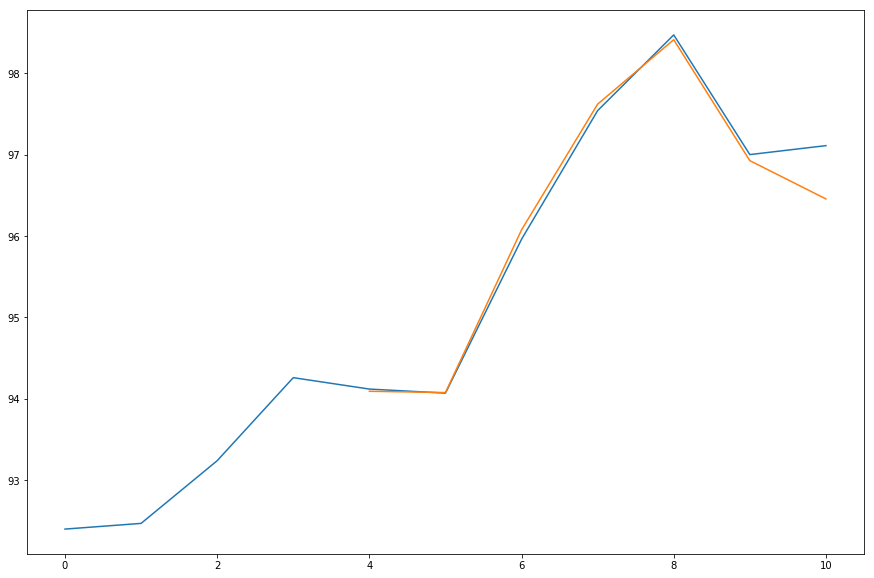

In [10]:
# plot baseline and predictions
plt.figure(figsize=(15, 10))
plt.plot(ds1)
plt.plot(ds2)
plt.show()

In [15]:
numebr_of_days = 200
first_day = len(df) - 1000  # Same start date that we used for the polynomial regression
res_actuals, res_predicted = predict_close_lstm(df, first_day, numebr_of_days, window_size=10, look_back=4, epochs=5000, plot=False, loss_threshold=1e-04)
root_mse = math.sqrt(mean_squared_error(res_actuals, res_predicted))
print("Root MSE: {}".format(root_mse))

Training day 0/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.04 RMSE
Training day 1/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.11 RMSE
Training day 2/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.02 RMSE
Training day 3/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.02 RMSE
Training day 4/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.02 RMSE
Training day 5/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.02 RMSE
Training day 6/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.16 RMSE
Training day 7/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.02 RMSE
Training day 8/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.04 RMSE
Training day 9/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.03 RMSE
Training day 10/200
Loss is lower than threshold of 0.0001. Quitting.
Train Scor

Train Score: 0.03 RMSE
Training day 92/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.03 RMSE
Training day 93/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.09 RMSE
Training day 94/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.05 RMSE
Training day 95/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.04 RMSE
Training day 96/200
Train Score: 0.83 RMSE
Training day 97/200
Train Score: 1.34 RMSE
Training day 98/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.22 RMSE
Training day 99/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.13 RMSE
Training day 100/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.13 RMSE
Training day 101/200
Loss is lower than threshold of 0.0001. Quitting.
Train Score: 0.13 RMSE
Training day 102/200


KeyboardInterrupt: 

## Speeding up
I train the models on my Lenovo T460P laptop. It's a Intel Core i7 with 8 cores.
<br>
However only 1 core out of 8 was running on 100% cpu while training the model.
<br>
Here are some ways that I tried speedup training:
- Use GPUs for Tensorflow backend > it seems that my laptop doesn't have an nVidia card installed
- Use tensorflow session settings to control number of CPUs used > didn't help
- Split the code to array of trained days to batches and run all of them in parallel by using Python multiprocessing > the code did run in parallel, but still only a single CPU was used
- Run on a machine in Amazon with GPU enabled > not an option - it founds out to be very expensive
- Run the epochs inside the model instead doing it externally and fitting with just 1 epoch > same results

I think that the problem is that epochs need to run sequentially, so the parallelism is done inside every epoch. 
<br>
But the network is so small and the number of samples is so small (only 10 with a window of 10), that the training of the epoch is finishing before getting to utilize all cores.